# Overfitting and Regularization

## Imports

In [198]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

import warnings
warnings.filterwarnings('ignore')

In [200]:
set_config(display='diagram')

## Settings

In [201]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [202]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

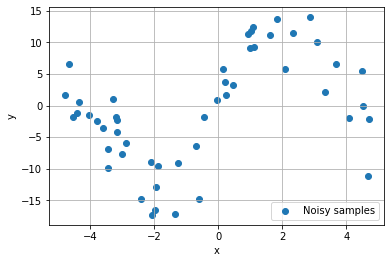

In [203]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

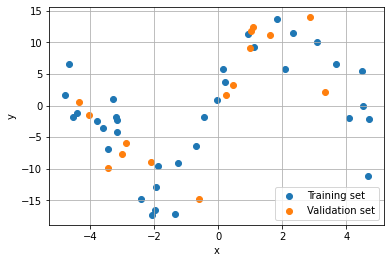

In [204]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [205]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [206]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [207]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

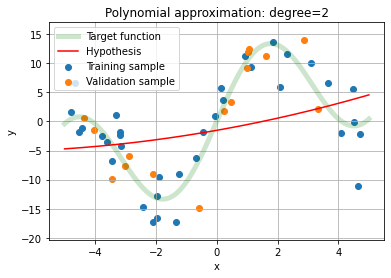

In [208]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

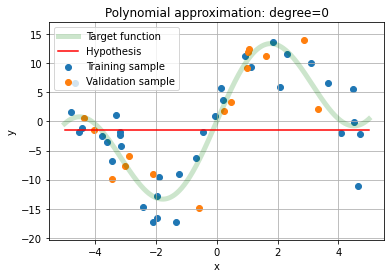

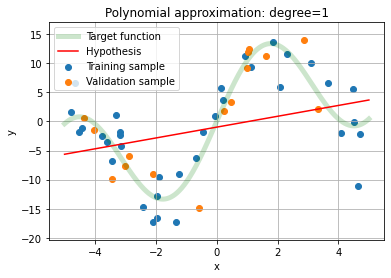

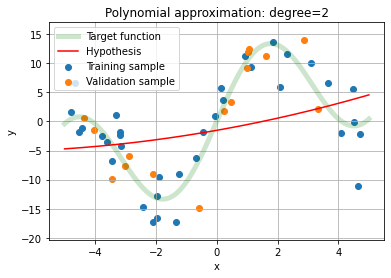

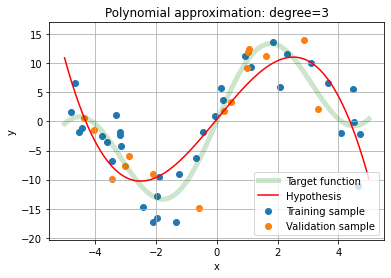

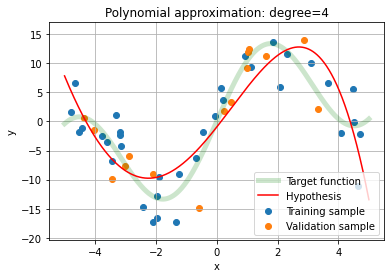

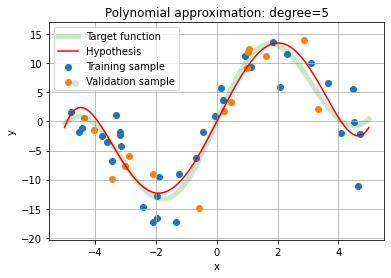

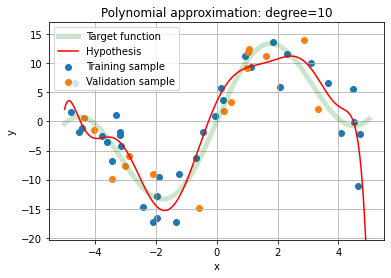

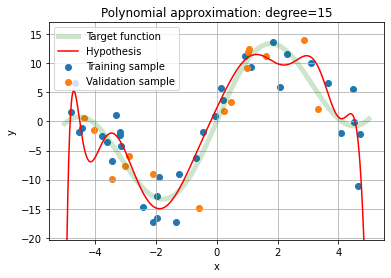

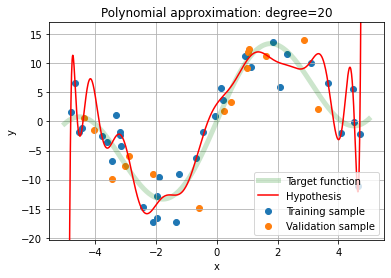

In [209]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

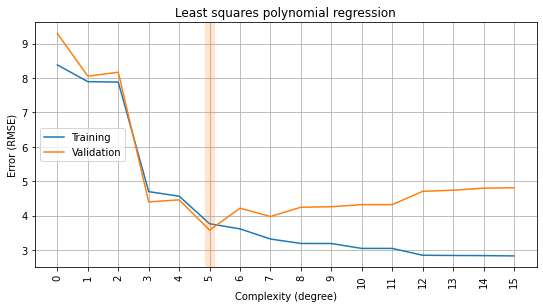

In [210]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [211]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

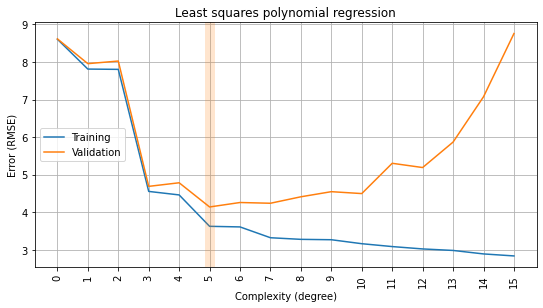

In [212]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [213]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

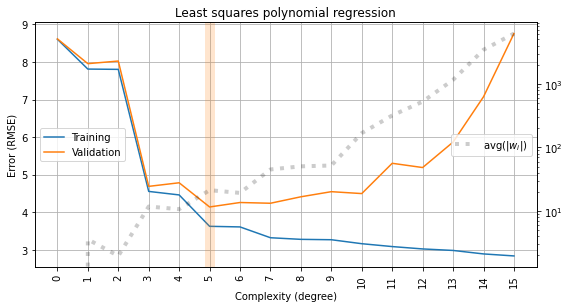

In [214]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

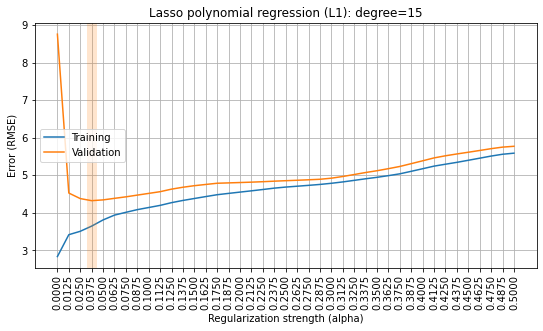

In [215]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

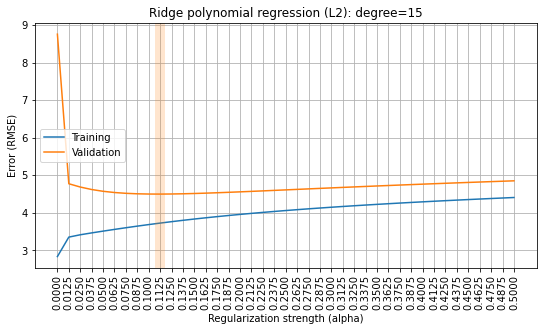

In [216]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [217]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

#### Correlation matrix
Построим корреляционную матрицу признаков.

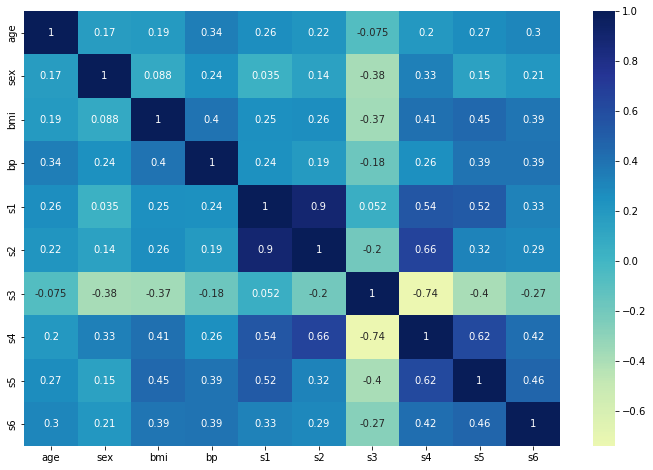

In [218]:
correlation_matrix = X_diabetes.corr(method='pearson')
plt.figure(figsize=(12,8))
sns.heatmap(data=correlation_matrix, annot=True, cmap='YlGnBu', center=0);

В представленном наборе нет коллинеарных признаков.

#### Split
Подготовим обучающую и тестовую выборку в отношении 7:3.

In [219]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

In [220]:
def get_partially_PolynomialFeatures(x_data: pd.DataFrame, degree, first_col_num):
    x_data_poly = x_data.iloc[:,:first_col_num]
    x_data_other = x_data.iloc[:,first_col_num:]
    
    result1 = PolynomialFeatures(degree, include_bias=(degree == 0)).fit_transform(x_data_poly)
    result2 = PolynomialFeatures(1).fit_transform(x_data_other)

    result = np.append(result1, result2, axis=1)
    return result

degree = 15
first_col_number = 6
x_poly = get_partially_PolynomialFeatures(X_train, degree, first_col_number)
x_poly.shape


(309, 54268)

Построим график зависимости ошибки предсказания модели `RMSE` от степени полинома `degree` для преобразования входных данных. Для построения будем использовать только линейную регрессию без регуляризации.

При этом пусть `degree` изменяется от 1 до 10. Нулевая степень не рассматривается, т.к. расчет для нее сопровождается ошибкой. Также не рассматриваются степени выше 10,т.к. характер зависимости можно оценить и на меньшем диапазоне.

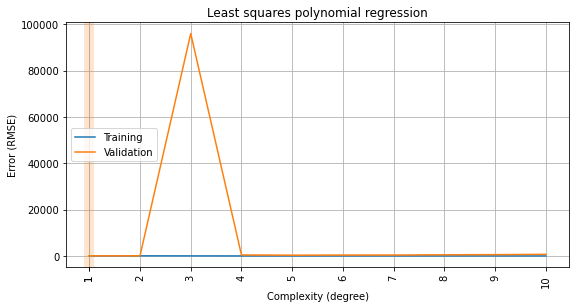

In [221]:
MAX_DEGREE = 10
DEGREES = np.linspace(1, MAX_DEGREE, MAX_DEGREE+1, dtype=int)

rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Как следует из графика выше, имеет место выброс для `degree=3`, не позволяющей оценить характер зависимости.
Исключим данную степень из расчетов и построим график заново.

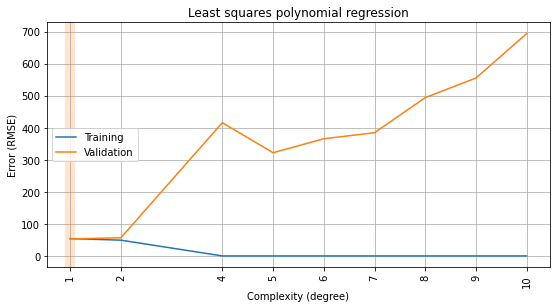

In [222]:
DEGREES = [1,2,4,5,6,7,8,9,10]

rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

#### Summary

- Как следует из графика, представленного выше, оптимальной степенью полином для преобразования признаков является `degree=1`. 
- Для степеней полинома `degree>1` формируется переобученная модель предсказания (overfitting), т.к. ошибка предсказания для тестовой выборки (validation) значительно превышает соотвествующую ошибку для обучающей выборки.
- Недообученная (underfitting) модель в данном случае не имеет место.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

Рассмотрим зависимость усредненной амплитуры весовых коэффициентов $|w_i|$ от силы регуляризации (значения `alpha`).

Для уменьшения вычислительной сложности и соблюдения условий задания (`degree=15`) выберем только 1 признак (первый, т.е. `age`) для полиномиального преобразования, а остальные признаки оставим нетронутыми.

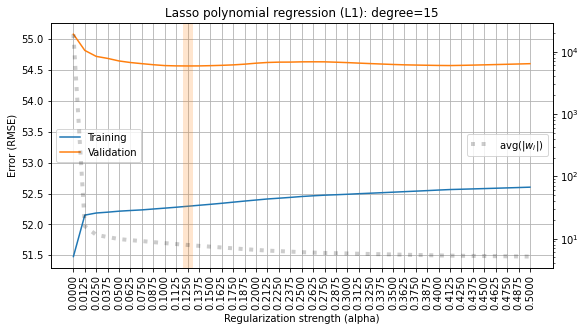

In [223]:
rmse_train_l1, rmse_valid_l1, avg_coef_l1 = [], [], []
first_col_num = 1
degree = 15
X_diabetes_poly = get_partially_PolynomialFeatures(X_diabetes, degree, first_col_num);
for alpha in ALPHAS:    
    results_l1 = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha), 
                             X_diabetes_poly, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_l1.append(-np.mean(results_l1['train_score']))
    rmse_valid_l1.append(-np.mean(results_l1['test_score']))
    avg_coef_l1.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results_l1['estimator']]))
    
plot_fitting_graph(ALPHAS, rmse_train_l1, rmse_valid_l1, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_l1, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')


#### L2

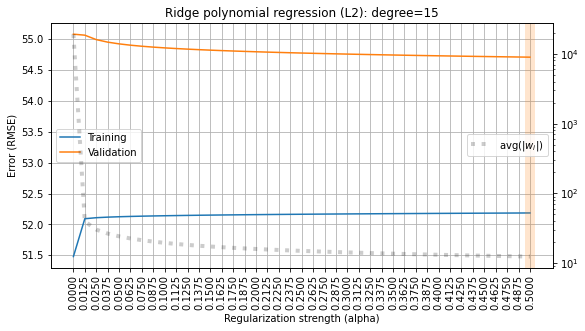

In [224]:
rmse_train_l2, rmse_valid_l2, avg_coef_l2 = [], [], []
for alpha in ALPHAS:    
    results_l2 = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha), 
                             X_diabetes_poly, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_l2.append(-np.mean(results_l2['train_score']))
    rmse_valid_l2.append(-np.mean(results_l2['test_score']))
    avg_coef_l2.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results_l2['estimator']]))
    
plot_fitting_graph(ALPHAS, rmse_train_l2, rmse_valid_l2, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   custom_metric=avg_coef_l2, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

#### Summary

- *Как следует из представленных выше графиков, с ростом значения `alpha` среднее значение весовых коэффициентов $|w_i|$ монотонно убывает как для Lasso-, так и для Ridge-регрессии.*
- *Максимальное среднее значение весовых коэффициентов для указанных типов регуляризации имеет место при `alpha=0`, что соответсвует случаю стандартной линейной регрессии (без регуляризации).*

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

Оценим зависимость числа ненулевых весовых коэффициентов ($w_i$) от силы L1- и L2-регуляризации (параметра `alpha`).

#### L1

In [225]:
nonzero_count_l1 = []
for alpha in ALPHAS:    
    results_l1 = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha), 
                             X_diabetes_poly, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    nonzero_count_l1.append(np.mean([np.sum(model['reg'].coef_ != 0) for model in results_l1['estimator']]))

#### L2

In [226]:
nonzero_count_l2 = []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha), 
                             X_diabetes_poly, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    nonzero_count_l2.append(np.mean([np.sum(model['reg'].coef_ != 0) for model in results['estimator']]))

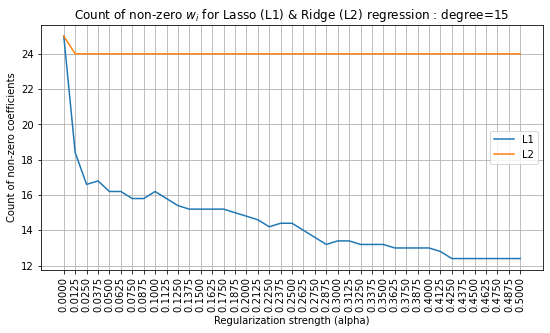

In [227]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, nonzero_count_l1, label='L1')
plt.plot(ALPHAS, nonzero_count_l2, label='L2')
plt.title('Count of non-zero $w_i$ for Lasso (L1) & Ridge (L2) regression : degree=15')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Count of non-zero coefficients')
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='center right')  

In [228]:
nonzero_count_l1_2 = []
nonzero_count_l1_5 = []
nonzero_count_l1_50 = []

X_diabetes_poly_2 = get_partially_PolynomialFeatures(X_diabetes, 2, first_col_num);
X_diabetes_poly_5 = get_partially_PolynomialFeatures(X_diabetes, 5, first_col_num);
X_diabetes_poly_50 = get_partially_PolynomialFeatures(X_diabetes, 50, first_col_num);

for alpha in ALPHAS:
    results_2 = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha), 
                             X_diabetes_poly_2, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    nonzero_count_l1_2.append(np.mean([np.sum(model['reg'].coef_ != 0) for model in results_2['estimator']]))
    
    results_5 = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha), 
                             X_diabetes_poly_5, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    nonzero_count_l1_5.append(np.mean([np.sum(model['reg'].coef_ != 0) for model in results_5['estimator']]))
    
    results_50 = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha), 
                             X_diabetes_poly_50, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    nonzero_count_l1_50.append(np.mean([np.sum(model['reg'].coef_ != 0) for model in results_50['estimator']]))

(5.0, 35.0)

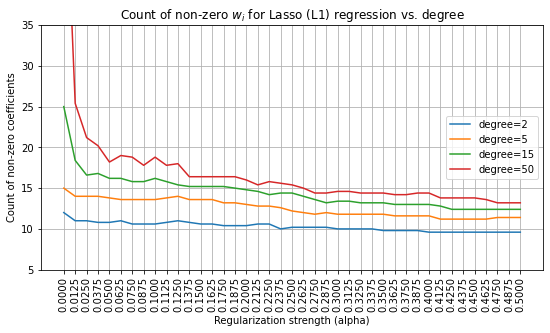

In [229]:
plt.figure(figsize=(9, 4.5))
plt.plot(ALPHAS, nonzero_count_l1_2, label='degree=2')
plt.plot(ALPHAS, nonzero_count_l1_5, label='degree=5')
plt.plot(ALPHAS, nonzero_count_l1, label='degree=15')
plt.plot(ALPHAS, nonzero_count_l1_50, label='degree=50')

plt.title('Count of non-zero $w_i$ for Lasso (L1) regression vs. degree')
plt.xlabel('Regularization strength (alpha)')
plt.ylabel('Count of non-zero coefficients')
plt.grid(True)
plt.xticks(ALPHAS, rotation='vertical')
plt.legend(loc='center right')  
plt.ylim(5, 35)

#### Summary

- *Как следует из графика выше, регуляризация на базе Lasso-регрессии приводит к тому, что значительная часть коэффициентов имеют нулевые значения. Это может быть интерпретировано как использование для предсказания только ограниченного набора ненулевых признаков, или feature selection. При этом чем выше сила регуляризации L1, тем меньшее число ненулевых коэффициентов используется для предсказания.*
- *В отличие от Lasso-регрессии, изненение силы регуляризации для Ridge-регрессии в рассмотренном примере не приводит к появлению значительного числа ненулевых коэффициентов $w_i$*.
- *L1-регрессия может быть использована для feature selection, при этом эффективность данного процесса напрямую будет зависеть от силы регуляризации. Данная закономерность подтвердилась для различной степени полиномиального преобразования признаков (`degree`).*

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [230]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


Определим функцию для формирования модели предсказания с/без использования нормализации (масштабирования) входных данных.

In [231]:
def make_model_1(degree, alpha=0, penalty=None, use_scaler=True, ):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    if (use_scaler == True):
        return Pipeline([
            ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
            ('sca', StandardScaler()),
            ('reg', regressor)
        ])
    else:
        return Pipeline([
            ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
            ('reg', regressor)    
    ])
    
display(make_model_1(2))
display(make_model_1(2, penalty='L1', alpha=0.1))
display(make_model_1(2, penalty='L2', alpha=0.1))
display(make_model_1(2, penalty='L2', alpha=0.1, use_scaler=False))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

In [232]:
 def plot_fitting_graph_1(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', 
                        title='Fitting graph', ylim=None):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    
    if (ylim != None):
        plt.ylim((0,ylim))
    plt.show()    

Сформирует обучающую и тестовую выборку в отношении 7:3.

In [233]:
X_train_hw, X_valid_hw, y_train_hw, y_valid_hw = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

Оценим следующие зависимости:
- влияние наличия/отсутствия нормализации данных на ошибку предсказания в обучающей и тестовой выборке при L1- и L2-регресии. 
- эффективность L1 и L2-регуляризации (необходимую силу регуляризации - параметр `alpha`) при наличии/отсутствии нормализации данных.

#### L1

In [234]:
MAX_DEGREE = 15
DEGREES = np.linspace(1, MAX_DEGREE, MAX_DEGREE+1, dtype=int)

# With MinMax-scaler
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model_1(degree,penalty='L1', alpha=0.1, use_scaler=True ).fit(X_train_hw, y_train_hw)
    rmse_train.append(rmse(reg.predict(X_train_hw), y_train_hw))
    rmse_valid.append(rmse(reg.predict(X_valid_hw), y_valid_hw))

# without MinMax-scaler
rmse_train_no_sc, rmse_valid_no_sc = [], []
for degree in DEGREES:
    reg = make_model_1(degree,penalty='L1', alpha=0.1, use_scaler=False ).fit(X_train_hw, y_train_hw)
    rmse_train_no_sc.append(rmse(reg.predict(X_train_hw), y_train_hw))
    rmse_valid_no_sc.append(rmse(reg.predict(X_valid_hw), y_valid_hw))

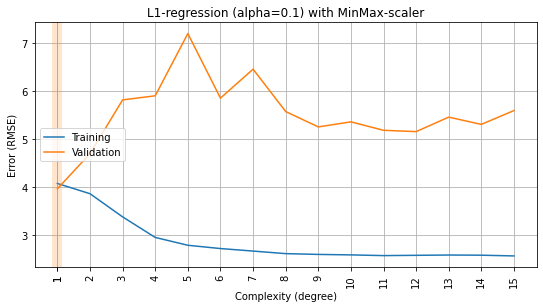

In [235]:
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='L1-regression (alpha=0.1) with MinMax-scaler')

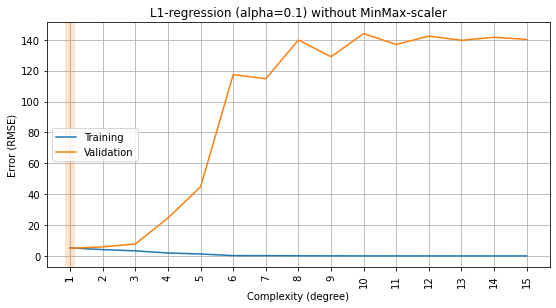

In [236]:
plot_fitting_graph(DEGREES, rmse_train_no_sc, rmse_valid_no_sc, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='L1-regression (alpha=0.1) without MinMax-scaler')

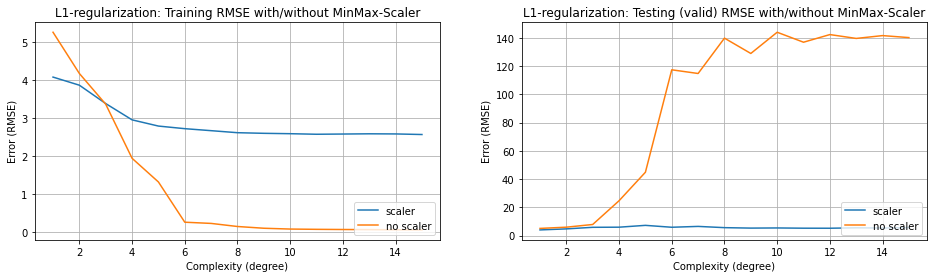

In [237]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,4))
axes[0].plot(DEGREES, rmse_train, label='scaler')
axes[0].plot(DEGREES, rmse_train_no_sc, label='no scaler')
axes[0].set_xlabel('Complexity (degree)')
axes[0].set_ylabel('Error (RMSE)')
axes[0].grid(True)
axes[0].set_title('L1-regularization: Training RMSE with/without MinMax-Scaler')
axes[0].legend(loc='lower right')

axes[1].plot(DEGREES, rmse_valid, label='scaler')
axes[1].plot(DEGREES, rmse_valid_no_sc, label='no scaler')
axes[1].set_xlabel('Complexity (degree)')
axes[1].set_ylabel('Error (RMSE)')
axes[1].grid(True)
axes[1].set_title('L1-regularization: Testing (valid) RMSE with/without MinMax-Scaler')
axes[1].legend(loc='lower right')

Из графиков выше следует, что использование ненормированных данных для L1-регрессии приводит к значительному увеличению ошибки предсказания (RMSE) для тестовой выборки и к снижению ошибки для обучающей выборки. Иными словами отсутствие нормировки приводит к увеличению степени переобученности модели предсказания (overfitting).

Теперь оценим эффективность регуляризации при наличии/отсутствии нормализации данных.

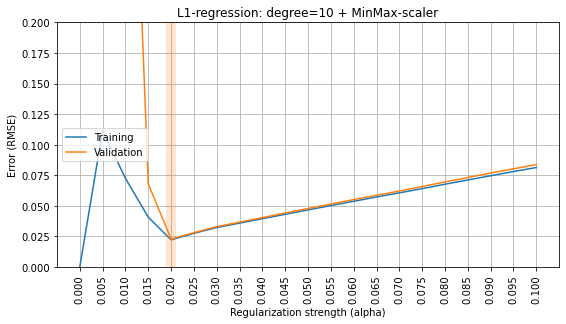

In [238]:
ALPHAS = np.linspace(0, 0.1, 1 + 20)

rmse_train_l1, rmse_valid_l1, avg_coef_l1 = [], [], []
degree = 10
for alpha in ALPHAS:    
    results_l1 = cross_validate(make_model_1(degree=degree, penalty='L1', alpha=alpha, use_scaler=True), 
                             X_hw, X_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_l1.append(-np.mean(results_l1['train_score']))
    rmse_valid_l1.append(-np.mean(results_l1['test_score']))
    avg_coef_l1.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results_l1['estimator']]))
    
pl = plot_fitting_graph_1(ALPHAS, rmse_train_l1, rmse_valid_l1, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='L1-regression: degree=10 + MinMax-scaler', ylim=0.2)

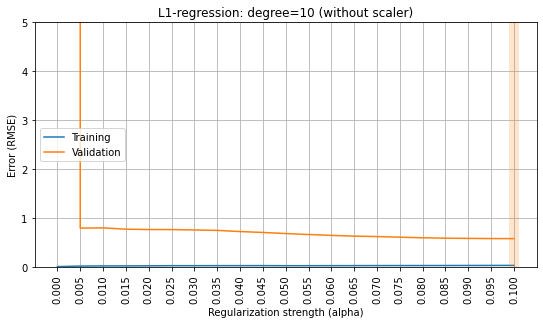

In [239]:
rmse_train_l1, rmse_valid_l1, avg_coef_l1 = [], [], []
degree = 10
for alpha in ALPHAS:    
    results_l1 = cross_validate(make_model_1(degree=degree, penalty='L1', alpha=alpha, use_scaler=False), 
                             X_hw, X_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_l1.append(-np.mean(results_l1['train_score']))
    rmse_valid_l1.append(-np.mean(results_l1['test_score']))
    avg_coef_l1.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results_l1['estimator']]))
    
pl = plot_fitting_graph_1(ALPHAS, rmse_train_l1, rmse_valid_l1, 
               xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
               title='L1-regression: degree=10 (without scaler)',
               ylim=5)

L1-регуляризация при отсутствии нормализации (масштабирования) данных значительно менее эффективна, на что указывает сходимость кривых ошибок для обучающей и тестовой выбор и результирующее значение `alpha`. Надо также заметить, что для ненормированных данных трубуется большая сила регуляризации,т.е. `alpha=0.1` вместо `alpha=0.02`.

#### L2

Оценим аналогичные зависимость для L2-регуляризации.

In [240]:
# With MinMax-scaler
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model_1(degree,penalty='L2', alpha=0.1, use_scaler=True ).fit(X_train_hw, y_train_hw)
    rmse_train.append(rmse(reg.predict(X_train_hw), y_train_hw))
    rmse_valid.append(rmse(reg.predict(X_valid_hw), y_valid_hw))

# without MinMax-scaler
rmse_train_no_sc, rmse_valid_no_sc = [], []
for degree in DEGREES:
    reg = make_model_1(degree,penalty='L2', alpha=0.1, use_scaler=False ).fit(X_train_hw, y_train_hw)
    rmse_train_no_sc.append(rmse(reg.predict(X_train_hw), y_train_hw))
    rmse_valid_no_sc.append(rmse(reg.predict(X_valid_hw), y_valid_hw))

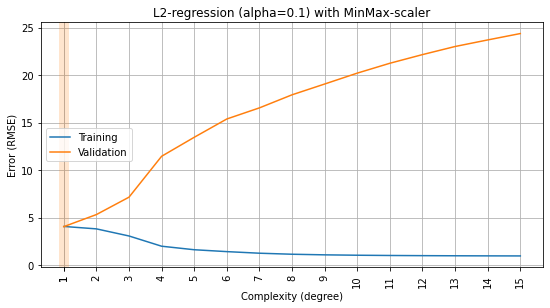

In [241]:
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='L2-regression (alpha=0.1) with MinMax-scaler')

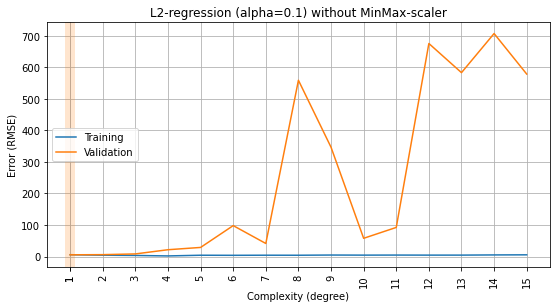

In [242]:
plot_fitting_graph(DEGREES, rmse_train_no_sc, rmse_valid_no_sc, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='L2-regression (alpha=0.1) without MinMax-scaler')

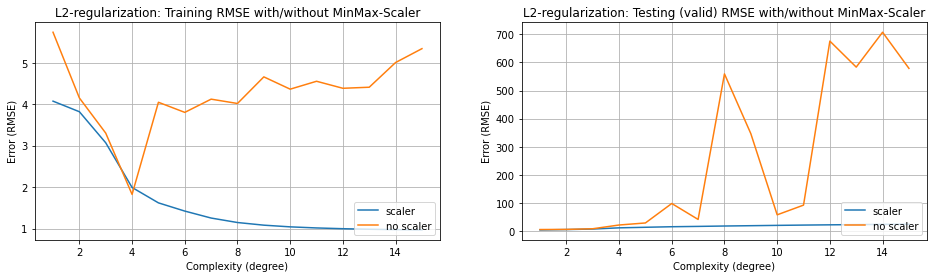

In [243]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,4))
axes[0].plot(DEGREES, rmse_train, label='scaler')
axes[0].plot(DEGREES, rmse_train_no_sc, label='no scaler')
axes[0].set_xlabel('Complexity (degree)')
axes[0].set_ylabel('Error (RMSE)')
axes[0].grid(True)
axes[0].set_title('L2-regularization: Training RMSE with/without MinMax-Scaler')
axes[0].legend(loc='lower right')

axes[1].plot(DEGREES, rmse_valid, label='scaler')
axes[1].plot(DEGREES, rmse_valid_no_sc, label='no scaler')
axes[1].set_xlabel('Complexity (degree)')
axes[1].set_ylabel('Error (RMSE)')
axes[1].grid(True)
axes[1].set_title('L2-regularization: Testing (valid) RMSE with/without MinMax-Scaler')
axes[1].legend(loc='lower right')

Из графиков выше следует:
- использование ненормированных данных в случае с L2-регуляризацией также приводит к увеличению степени переобученности модели предсказания. При этом в отличие от L1-регуляризации, при L2-регуляризации также возрастает, а не убывает ошибка RMSE для тестовой выборки.
- Как для L1-, так и для L2-регуляризации кривая зависимости ошибки предсказания (`RMSE`) от степени полинома (`degree`) не является монотонной, что означает повышенную чувствительно к стохастическому шуму.

Далее оценим эффективность L2-регуляризации при отсуствии нормализации данных.

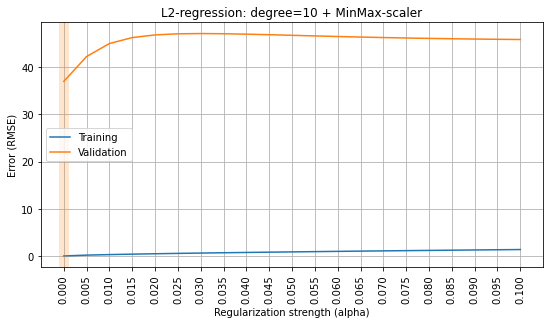

In [247]:
ALPHAS = np.linspace(0, 0.10, 1 + 20)

rmse_train_l2, rmse_valid_l2, avg_coef_l2 = [], [], []
degree = 10
for alpha in ALPHAS:
    results_l2 = cross_validate(make_model_1(degree=degree, penalty='L2', alpha=alpha, use_scaler=True), 
                             X_hw, X_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_l2.append(-np.mean(results_l2['train_score']))
    rmse_valid_l2.append(-np.mean(results_l2['test_score']))
    avg_coef_l2.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results_l2['estimator']]))
    
pl = plot_fitting_graph_1(ALPHAS, rmse_train_l2, rmse_valid_l2, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='L2-regression: degree=10 + MinMax-scaler')

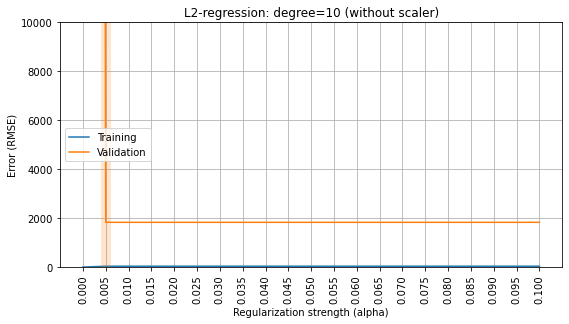

In [248]:
rmse_train_l2, rmse_valid_l2, avg_coef_l2 = [], [], []
degree = 10
for alpha in ALPHAS:    
    results_l2 = cross_validate(make_model_1(degree=degree, penalty='L2', alpha=alpha, use_scaler=False), 
                             X_hw, X_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_l2.append(-np.mean(results_l2['train_score']))
    rmse_valid_l2.append(-np.mean(results_l2['test_score']))
    avg_coef_l2.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results_l2['estimator']]))
    

pl = plot_fitting_graph_1(ALPHAS, rmse_train_l2, rmse_valid_l2, 
               xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
               title='L2-regression: degree=10 (without scaler)',
               ylim=10000)

- Как и в случае с L1, отсутствие нормализации входных данных приводит к необходимости использования больших значений `alpha` для компенсации повышенной чувствительности с стохастическому шуму. 
- Как для L1-, так и для L2-регрессии при отсутствии нормализации входных признаков требуется большая сила регуляризаци, чем при ее наличии. При этом степень влияния отсутствия нормализации на эффективность L2-регуляризации значительно меньше, чем на L1-регуляризацию.

#### Summary



- *Числовые признаки в интересующем нас наборе данных могут иметь значительные отличия в абсолютных величинах (разница может достигать нескольких порядков). Поэтому при использовании регрессии весовые коэффициенты для них будет значительно отличаться, т.е. удельный вклад одного из параметров может быть значительно больше удельного вклада другого, что, в свою очередь, затрудняет процесс регуляризации, т.е. по сути процесс минимизации весовых коэффициентов. Это объясняется тем, что влияние параметров регуляризации на весовые коэффициенты будет неравномерным.*
- *Числовые параметры могут быть значительно смещены относительно начала координат, например, рост среднестатистического человека заведомо лежит в диапазоне от 1.6 до 2 метров. В данном случае при использовании всего диапазона от 0 до 2 м. регрессия при регаляризации будет стремиться к линейной зависимости. Для повышение точности описания зависимостей логичным выглядит рассмотрение только диапазона от 1.6 до 2 м, что и обеспечивает нормализация (например, MinMax).*
- *Использование ненормированных данных в случае с L1- и L2-регуляризацией приводит к увеличению степени переобученности модели предсказания. При этом как для L1-, так и для L2-регуляризации кривая зависимости ошибки предсказания (RMSE) от степени полинома (`degree`) не является монотонной, что означает повышенную чувствительность модели к стохастическому шуму.*
- *Для L1- и L2-регрессий при отсутствии нормализации входных признаков для компенсации повышенной чувствительности к стохастическому шуму требуется большая сила регуляризаци, чем при ее наличии. При этом отсутствия нормализации в большей степени снижает эффективность L1-регуляризации, чем L2-регуляризацию.* 